# Impacts of Cylindrical Symmetry for a top casing source

- casing in a half-space
- simulate in 2D, 3D on cyl mesh
- frequencies from 1e-1 to 2 Hz

In [1]:
import time
import discretize
from discretize import utils
import numpy as np
import scipy.sparse as sp

import properties
import sympy
from scipy.constants import mu_0

from SimPEG.EM import FDEM
from SimPEG import Utils, Maps

import casingSimulations

from pymatsolver import Pardiso

import matplotlib.pyplot as plt
%matplotlib inline

/Users/lindseyjh/git/python_symlinks/properties/basic.py:36: FutureWarning: Deprecation warning: info_text has been renamed class_info. Consider updating class Model 
  'Consider updating class {} '.format(name), FutureWarning)
/Users/lindseyjh/git/python_symlinks/properties/basic.py:36: FutureWarning: Deprecation warning: info_text has been renamed class_info. Consider updating class Mapping 
  'Consider updating class {} '.format(name), FutureWarning)
/Users/lindseyjh/git/python_symlinks/properties/basic.py:36: FutureWarning: Deprecation warning: info_text has been renamed class_info. Consider updating class PhysicalProperty 
  'Consider updating class {} '.format(name), FutureWarning)


In [2]:
sigma_back = 1e-1 # wholespace

# top casing source
cp = casingSimulations.CasingParameters(
    casing_l = 1000., # 1km long casing
    src_a = np.r_[0., np.pi, 0.], # the source fcts will take care of coupling it to the casing
    src_b = np.r_[1e3, np.pi, 0.], # return electrode  
    freqs = np.r_[0.5, 1., 2.],
    sigma_back = sigma_back,
    sigma_layer = sigma_back,    
)
print('Casing Parameters: \n')
cp.serialize()

Casing Parameters: 



{u'__class__': 'CasingParameters',
 'casing_d': 0.1,
 'casing_l': 1000.0,
 'casing_t': 0.01,
 'casing_top': 0.0,
 'freqs': [0.5, 1.0, 2.0],
 'layer_z': [-1000.0, -900.0],
 'mur_casing': 100.0,
 'sigma_air': 1e-08,
 'sigma_back': 0.1,
 'sigma_casing': 5500000.0,
 'sigma_inside': 1.0,
 'sigma_layer': 0.1,
 'src_a': [0.0, 3.141592653589793, 0.0],
 'src_b': [1000.0, 3.141592653589793, 0.0],
 'version': u'0.0.1'}

In [3]:
directory = './Impacts_of_cyl_symmetry_top_casing_multifreq'
cp.save(directory=directory)

In [4]:
print('skin depths in casing: ', cp.skin_depth(sigma=cp.sigma_casing, mu=cp.mur_casing*mu_0))
print('casing thickness: ',  cp.casing_t)

('skin depths in casing: ', array([ 0.03034966,  0.02146045,  0.01517483]))
('casing thickness: ', 0.01)


In [5]:
print('skin depths in background: ', cp.skin_depth())

('skin depths in background: ', array([ 2250.79079039,  1591.54943092,  1125.3953952 ]))


# Set up meshes

In [6]:
npadx, npadz = 9, 18
dx2 = 200. 
csz = 0.5

meshGen2D = casingSimulations.CasingMeshGenerator(
    cp=cp, npadx=npadx, npadz=npadz, domain_x2=dx2, csz=csz
)
mesh2D = meshGen2D.mesh

print(mesh2D.vectorNx.max(), mesh2D.vectorNz.min(), mesh2D.vectorNz.max())

(3108.251953125, -3217.8378200531006, 2217.8378200531006)


In [7]:
ncy = 1
nstretchy = 3
stretchfact = 1.6
hy = utils.meshTensor([(1, nstretchy, -stretchfact), (1, ncy), (1, nstretchy, stretchfact)])
hy = hy * 2*np.pi/hy.sum()

In [8]:
meshGen3D = casingSimulations.CasingMeshGenerator(
    cp=cp, npadx=npadx, npadz=npadz, domain_x2=dx2, hy=hy, csz=csz
)

mesh3D = meshGen3D.mesh

In [9]:
meshGen2D.save(directory=directory, filename='meshGen2D.json')
meshGen3D.save(directory=directory, filename='meshGen3D.json')

/anaconda/lib/python2.7/site-packages/matplotlib/projections/polar.py:65: RuntimeWarning: invalid value encountered in less
  mask = r < 0


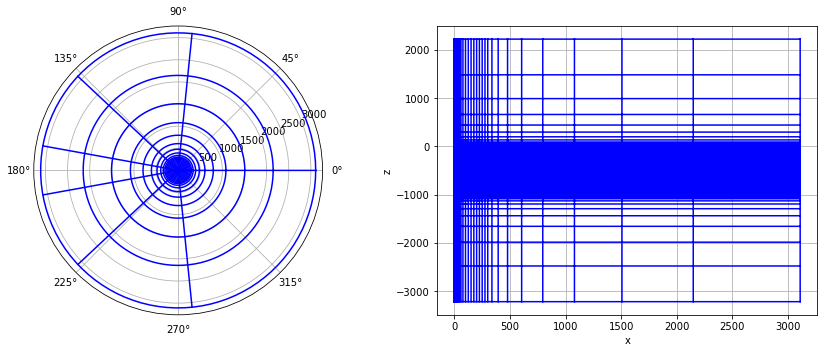

In [10]:
mesh3D.plotGrid()

## Generate the source and plot its path

In [11]:
src2D = casingSimulations.sources.TopCasingSrc(cp=cp, mesh=mesh2D)
src3D = casingSimulations.sources.TopCasingSrc(cp=cp, mesh=mesh3D)

(-2.5, 2.5)

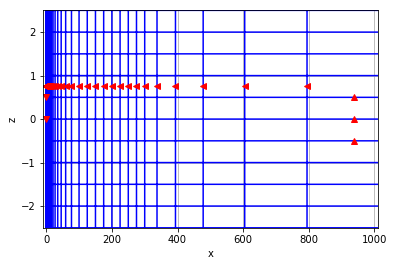

In [12]:
fig, ax = plt.subplots(1,1)
mesh2D.plotGrid(ax=ax)
src2D.plot(ax=ax)
ax.set_xlim([-10,1010.])
ax.set_ylim(0.5*np.r_[-5., 5.])

(-2.5, 2.5)

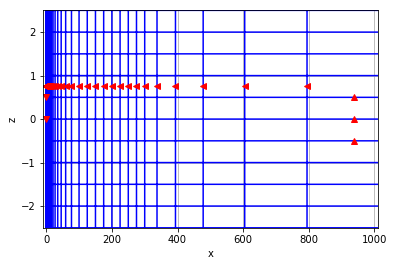

In [13]:
fig, ax = plt.subplots(1,1)
mesh2D.plotGrid(ax=ax)
src3D.plot(ax=ax)
ax.set_xlim([-10,1010.])
ax.set_ylim(0.5*np.r_[-5., 5.])

In [14]:
# validate the source terms
src3D.validate()
src2D.validate()

True

(0.0, 1500)

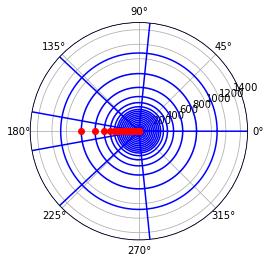

In [15]:
ax = plt.subplot(111, projection='polar')
mesh3D.plotGrid(ax=ax, slice='z')
ax.plot(mesh3D.gridFx[src3D.surface_wire,1], mesh3D.gridFx[src3D.surface_wire,0], 'ro')
ax.set_rlim([0., 1500])

# Look at physical properties on mesh

In [16]:
physprops2D = casingSimulations.PhysicalProperties(mesh2D, cp)
physprops3D = casingSimulations.PhysicalProperties(mesh3D, cp)

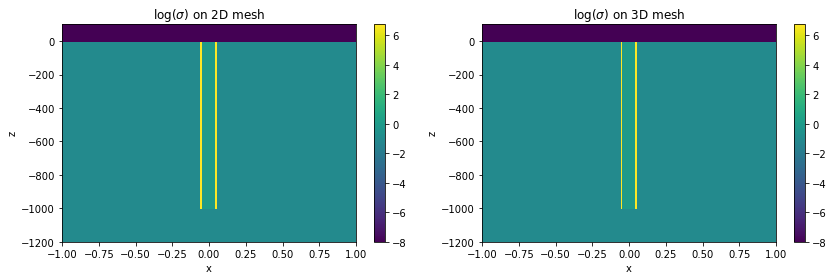

In [17]:
xlim = [-1., 1]
ylim = [-1200., 100.]
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plt.colorbar(
    mesh2D.plotImage(np.log10(physprops2D.sigma), ax=ax[0], mirror=True)[0], ax=ax[0]
)
ax[0].set_xlim(xlim)
ax[0].set_ylim(ylim)
ax[0].set_title('$\log(\sigma)$ on 2D mesh')

sigmaplt = physprops3D.sigma.reshape(mesh3D.vnC, order='F')

plt.colorbar(mesh2D.plotImage(np.log10(utils.mkvc(sigmaplt[:,0,:])), ax=ax[1], mirror=True)[0], ax=ax[1])
ax[1].set_xlim(xlim)
ax[1].set_ylim(ylim)
ax[1].set_title('$\log(\sigma)$ on 3D mesh')

plt.tight_layout()

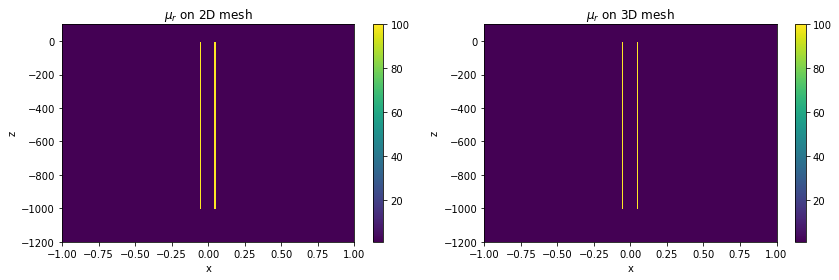

In [18]:
xlim = [-1., 1]
ylim = [-1200., 100.]
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plt.colorbar(
    mesh2D.plotImage(physprops2D.mur, ax=ax[0], mirror=True)[0], ax=ax[0]
)
ax[0].set_xlim(xlim)
ax[0].set_ylim(ylim)
ax[0].set_title('$\mu_r$ on 2D mesh')


murplt = physprops3D.mur.reshape(mesh3D.vnC, order='F')

plt.colorbar(mesh2D.plotImage(utils.mkvc(murplt[:,0,:]), ax=ax[1], mirror=True)[0], ax=ax[1])
ax[1].set_xlim(xlim)
ax[1].set_ylim(ylim)
ax[1].set_title('$\mu_r$ on 3D mesh')

plt.tight_layout()

# Load the results from simulation

In [19]:
# deserealize properties
meshGen2D=casingSimulations.load_properties('/'.join([directory, 'meshGen2D.json']))
meshGen3D=casingSimulations.load_properties('/'.join([directory, 'meshGen3D.json']))
cp=casingSimulations.load_properties('/'.join([directory, 'casingParameters.json']))

In [20]:
# load fields
hfield2D = np.load('/'.join([directory, 'fields2D.npy']))
hfield3D = np.load('/'.join([directory, 'fields3D.npy']))

In [21]:
# set up the pieces of the 2D simulation
sim2D = casingSimulations.run.SimulationFDEM(cp=cp, meshGenerator=meshGen2D, srcType='TopCasingSrc')
sim2D.prob.model = sim2D.physprops.model
fields2D = sim2D.prob.fieldsPair(meshGen2D.mesh, sim2D.survey)
fields2D[:,'hSolution'] = hfield2D
srcList2D = sim2D.survey.srcList

In [22]:
# set up the pieces of the 3D simulation
sim3D = casingSimulations.run.SimulationFDEM(cp=cp, meshGenerator=meshGen3D, srcType='TopCasingSrc')
sim3D.prob.model = sim3D.physprops.model
fields3D = sim3D.prob.fieldsPair(meshGen3D.mesh, sim3D.survey)
fields3D[:,'hSolution'] = hfield3D
srcList3D = sim3D.survey.srcList

## Current density

Grab a theta slice through the 3D cyl mesh

In [23]:
src_ind = 1
theta_ind = 3 # 3 is where the sources are aligned

j3Dslice = casingSimulations.face3DthetaSlice(
    mesh3D, fields3D[srcList3D[src_ind],'j'], theta_ind=theta_ind
)

j2D = fields2D[srcList2D[src_ind],'j']

print('frequency: {} Hz'.format(srcList3D[src_ind].freq))

frequency: 1.0 Hz


### J Real

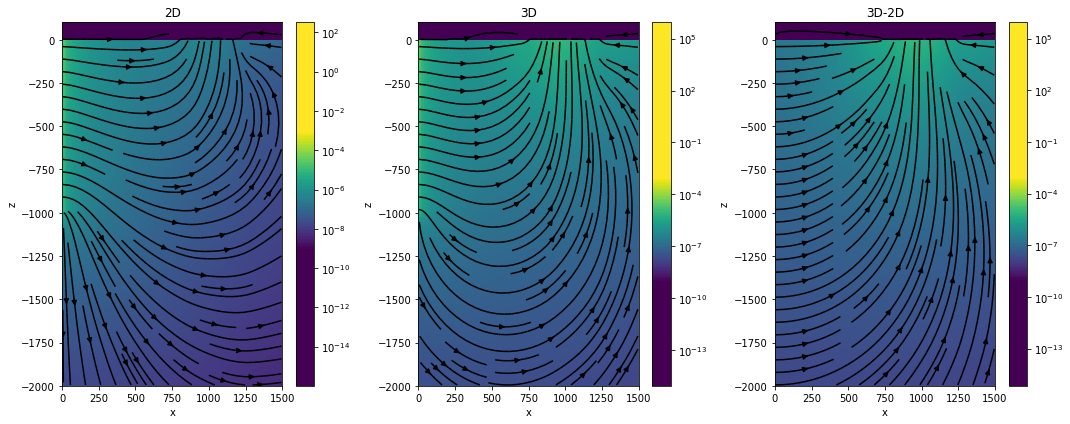

In [ ]:
# Look Deep into reservoir
fig, ax = plt.subplots(1,3,figsize=(15,6))

[
    casingSimulations.plotFace2D(
        mesh2D, 
        f, 
        real_or_imag='real', 
        range_x=np.r_[0., 1500.],
        range_y=np.r_[-2000., 100.],
        sample_grid=np.r_[10., 10.],
        clim=[1e-9, 1e-3],
        logScale=True, 
        ax=a
    ) 
    for f, a in zip([j2D, j3Dslice, j3Dslice - j2D], ax)
]

ax[0].set_title('2D')
ax[1].set_title('3D')
ax[2].set_title('3D-2D')

plt.tight_layout()

In [ ]:
# Look right next to casing
fig, ax = plt.subplots(1,3,figsize=(15,6))

[
    casingSimulations.plotFace2D(
        mesh2D, 
        f, 
        real_or_imag='real', 
        range_x=np.r_[0., 0.5],
        range_y=np.r_[-2000., 100.],
        sample_grid=np.r_[0.01, 10.],
        clim=np.r_[1e-10, 1e1],
        logScale=True, 
        ax=a
    ) 
    for f, a in zip([j2D, j3Dslice, j3Dslice - j2D], ax)
]

ax[0].set_title('2D')
ax[1].set_title('3D')
ax[2].set_title('3D-2D')

plt.tight_layout()

### J imag

In [ ]:
# imaginary part, far into reservoir
fig, ax = plt.subplots(1, 3, figsize=(15,6))

[
    casingSimulations.plotFace2D(
        mesh2D, 
        f, 
        real_or_imag='imag', 
        range_x=np.r_[0., 1500.],
        range_y=np.r_[-2000., 100.],
        sample_grid=np.r_[10., 10.],
        clim=[1e-11, 1e-3],
        logScale=True, 
        ax=a
    ) 
    for f, a in zip([j2D, j3Dslice, j3Dslice - j2D], ax)
]

ax[0].set_title('2D')
ax[1].set_title('3D')
ax[2].set_title('3D-2D')

plt.tight_layout()

In [ ]:
# imaginary part, far into reservoir
fig, ax = plt.subplots(1, 3, figsize=(15,6))

[
    casingSimulations.plotFace2D(
        mesh2D, 
        f, 
        real_or_imag='imag', 
        range_x=np.r_[0., 0.5],
        range_y=np.r_[-2000., 100.],
        sample_grid=np.r_[0.01, 10.],
        clim=[1e-11, 1e0],
        logScale=True, 
        ax=a
    ) 
    for  f, a in zip([j2D, j3Dslice, j3Dslice - j2D], ax)
]

ax[0].set_title('2D')
ax[1].set_title('3D')
ax[2].set_title('3D-2D')

plt.tight_layout()

## Electric Fields

In [ ]:
ecyl = fields3D[srcList3D[src_ind], 'e']
eslice = casingSimulations.utils.ccv3DthetaSlice(mesh3D, ecyl, theta_ind=theta_ind)

In [ ]:
ex = eslice[:mesh2D.nC]
ey = eslice[mesh2D.nC:2*mesh2D.nC]
ez = eslice[2*mesh2D.nC:]

e2D = fields2D[srcList2D[src_ind], 'e']
e3Dslice = np.vstack([ex, ez])

### E real

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 6))
[
    casingSimulations.plotFace2D(
        mesh2D, 
        f, 
        real_or_imag='real', 
        range_x=np.r_[0., 1500.],
        range_y=np.r_[-2000., 100.],
        sample_grid=np.r_[10., 10.],
        clim=[1e-8, 1e-3],
        logScale=True, 
        ax=a
    ) 
    for f, a in zip([e2D, e3Dslice, e3Dslice - e2D], ax)
]

plt.tight_layout()
ax[0].set_title('e2D')
ax[1].set_title('e3D')
ax[2].set_title('e3D-e2D')

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 6))
[
    casingSimulations.plotFace2D(
        mesh2D, 
        f, 
        real_or_imag='real', 
        range_x=np.r_[0., 0.5],
        range_y=np.r_[-2000., 100.],
        sample_grid=np.r_[0.01, 10.],
        clim=[1e-9, 1e-1],
        logScale=True, 
        ax=a
    ) 
    for f, a in zip([e2D, e3Dslice, e3Dslice - e2D], ax)
]

plt.tight_layout()
ax[0].set_title('e2D')
ax[1].set_title('e3D')
ax[2].set_title('e3D-e2D')

### E imag

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 6))

[
    casingSimulations.plotFace2D(
        mesh2D, 
        f, 
        real_or_imag='imag', 
        range_x=np.r_[0., 1500.],
        range_y=np.r_[-2500., 100.],
        sample_grid=np.r_[10., 10.],
        clim=[1e-9, 1e-4],
        logScale=True, 
        ax=a
    ) 
    for f, a in zip([e2D, e3Dslice, e3Dslice - e2D], ax)
]

plt.tight_layout()
ax[0].set_title('e2D')
ax[1].set_title('e3D')
ax[2].set_title('e3D-e2D')

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 6))

[
    casingSimulations.plotFace2D(
        mesh2D, 
        f, 
        real_or_imag='imag', 
        range_x=np.r_[0., 0.5],
        range_y=np.r_[-2500., 100.],
        sample_grid=np.r_[0.01, 10.],
        clim=[1e-10, 1e-1],
        logScale=True, 
        ax=a
    ) 
    for f, a in zip([e2D, e3Dslice, e3Dslice - e2D], ax)
]

plt.tight_layout()
ax[0].set_title('e2D')
ax[1].set_title('e3D')
ax[2].set_title('e3D-e2D')